## i. Perkenalan

=================================================

Nama  : Sulthan Fachry Inadamar

=================================================

Objective : Melakukan analisa dan memprediksi seberapa populer wisata Pulau Pari di minggu depan menggunakan metode forecasting time series.

---

## ii. Import Libraries

In [151]:
# Dataframe
import pandas as pd
import numpy as np
from datetime import datetime

# Visual
import matplotlib.pyplot as plt

# Model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

---

## iii. Data Loading

In [86]:
df = pd.read_csv('timeseries.csv')

df.head()

,Week,Pulau Pari: (Indonesia)
0,2022-03-27,16
1,2022-04-03,13
2,2022-04-10,18
3,2022-04-17,29
4,2022-04-24,35


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Week                     126 non-null    object
 1   Pulau Pari: (Indonesia)  126 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


- Dataframe sudah sesuai
- Terdapat 2 kolom Week dan Pulau Pari
- Memiliki 126 baris
- Tidak ada missing value
- Kolom Week dengan datatype object
- Kolom Pulau Pari dengan datatype int64

In [79]:
df.isnull().sum() # Cek missing value

Week                       0
Pulau Pari: (Indonesia)    0
dtype: int64

In [88]:
df.Week = pd.to_datetime(df.Week)

In [89]:
df = df.set_index('Week')['Pulau Pari: (Indonesia)'] # set week sebagai index
df = pd.DataFrame(df) 
df.head()

,Pulau Pari: (Indonesia)
Week,
2022-03-27,16
2022-04-03,13
2022-04-10,18
2022-04-17,29
2022-04-24,35


## iv. EDA

### Visual Data

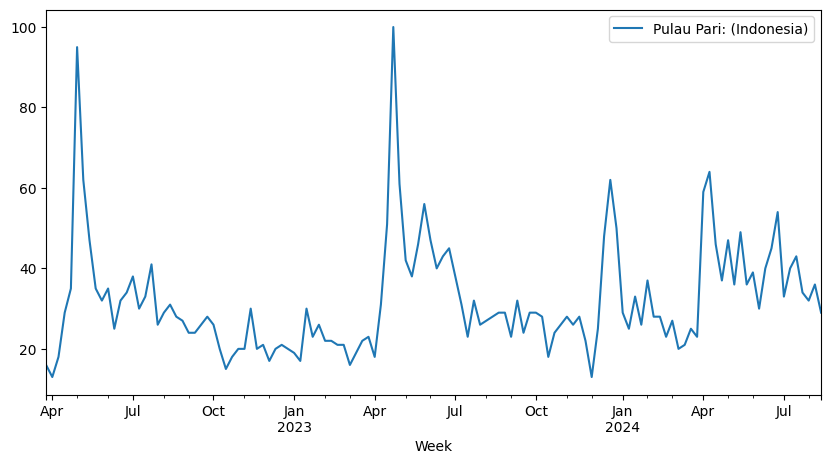

In [90]:
df.plot(figsize=(10,5))
plt.show()

- Berdasarkan grafis diatas terlihat bahwa datanya memiliki karakteristik **Multiplicative**

### Decompose

<Figure size 640x480 with 0 Axes>

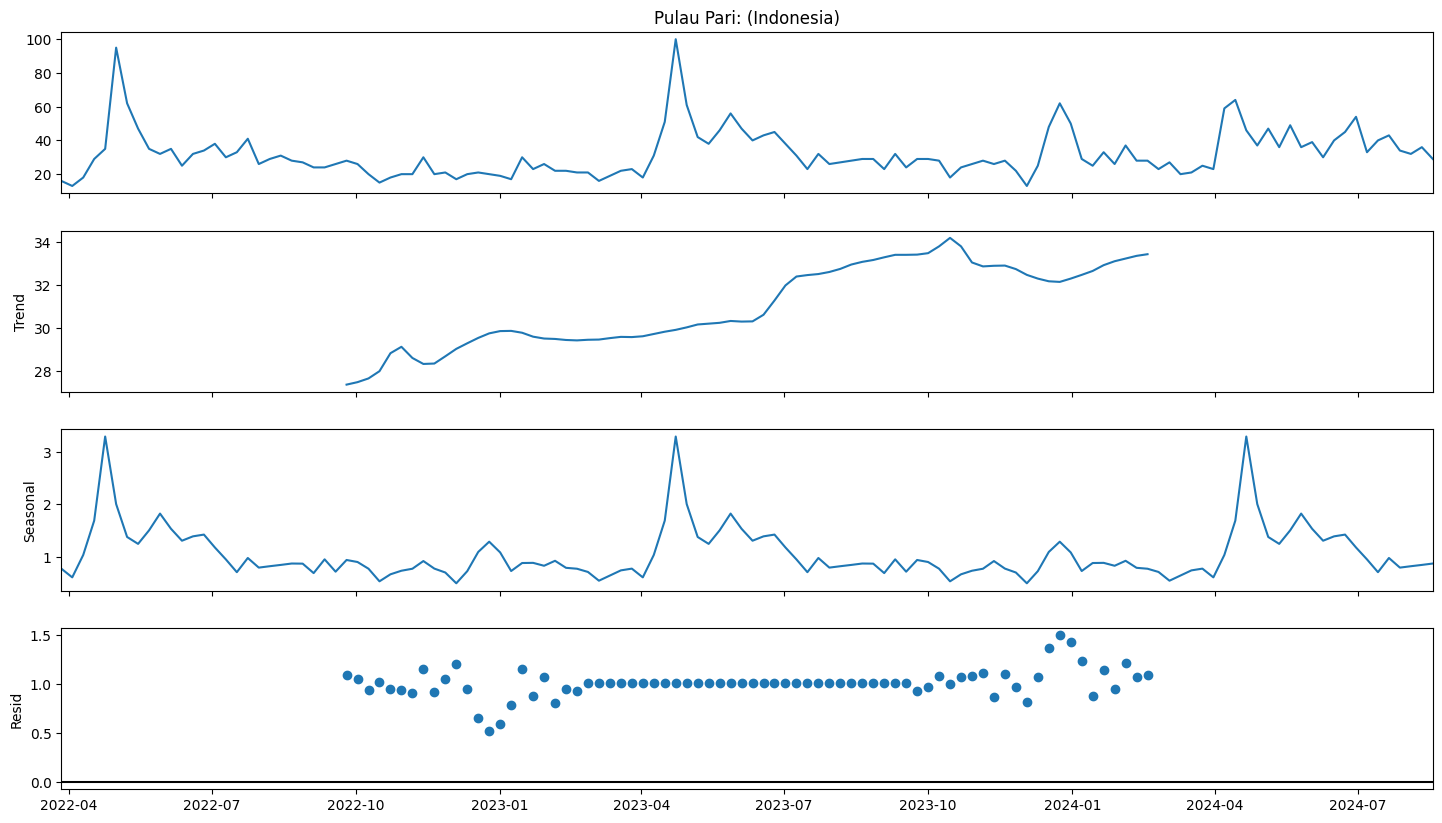

In [92]:
# decompose the components from the time series.
result = seasonal_decompose(df['Pulau Pari: (Indonesia)'], model='multiplicative')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()

- Pada grafis ini terlihat bahwa trend meningkat seiring jalannya waktu.
- Grafis terlihat stationary.
- Pada grafis seasonal terlihat setiap bulan mei ada peningkatan.

### Uji Stasioner

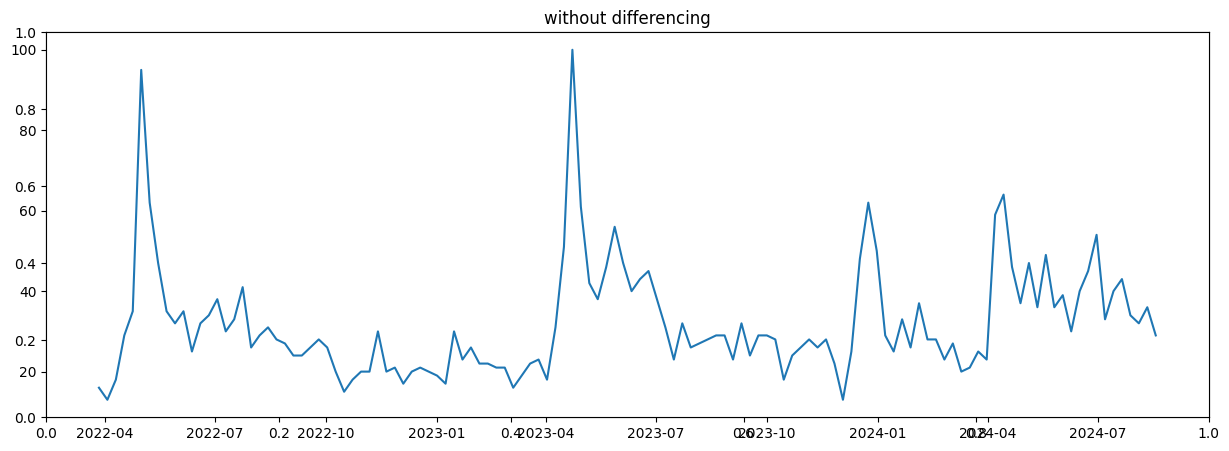

In [93]:
# Sebelum melakukan uji tes stasioner
fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.plot(df['Pulau Pari: (Indonesia)'])

In [94]:
# create function to check stationarity
def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [95]:
# Check stationarity of the dataset

check_stationarity(df['Pulau Pari: (Indonesia)'])

ADF Statistic: -3.893116
p-value: 0.002086
Critical Values:
	1%: -3.485
	5%: -2.886
	10%: -2.580
Stationary


- Dari hasil diatas, dapat dikonfirmasikan bahwa data termasuk dalam golongan stationary. Sehingga tidak perlu di differencing

### ACF & PACF

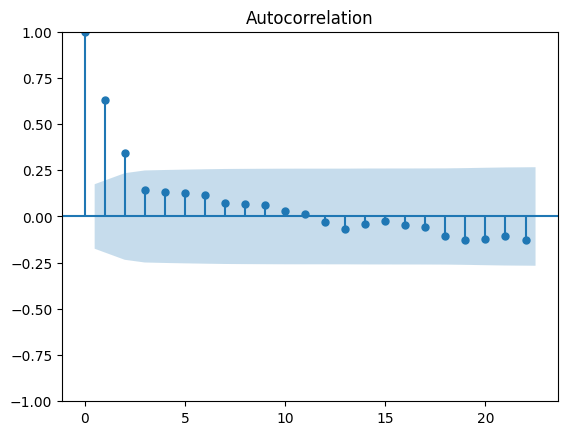

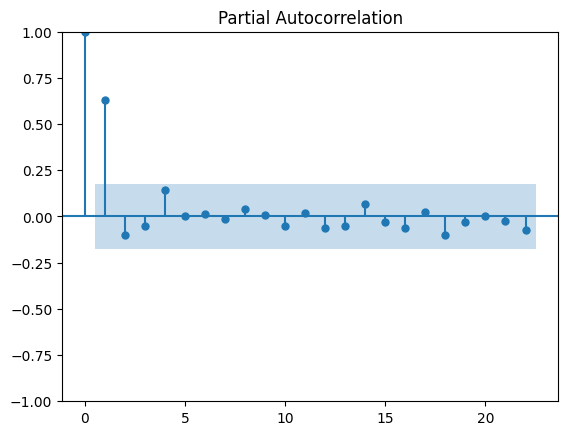

In [98]:
# Plot ACF & PACF from the original dataset

plot_acf(df['Pulau Pari: (Indonesia)'])
plot_pacf(df['Pulau Pari: (Indonesia)'])
plt.show()

Dari grafik diatas dapat disimpulkan:
- Pada ACF value 1 dan 2 berada diluar plot
- pada PACF value 1 berada diluar plot

Value diatas akan digunakan pada saat menggunakan model ARIMA/SARIMA

## v. Model Definition and Model Training

### Splitting dataset

In [135]:
# splitting dataset
train = df[:90]
test = df[90:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (90, 1)
Test size :  (36, 1)


### Model Definition

In [136]:
# create ARIMA function to find best model
def find_best_model(train, num_p, num_d, num_q):
  df = pd.DataFrame()
  # default value
  pdq = [[],[],[]]
  aic = []
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(train, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

In [137]:
# find best model of ARIMA with combinations of p=4, d=4, q=4
find_best_model(df, 4, 4, 4)

c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No 

(np.int64(1),
 np.int64(1),
 np.int64(1),
 np.float64(957.5078938688234),
     p  d  q          AIC
 31  1  1  1   957.507894
 8   0  1  3   958.287105
 56  2  1  1   958.577184
 32  1  1  2   958.727801
 33  1  1  3   958.933844
 .. .. .. ..          ...
 70  2  4  0  1185.841117
 21  0  4  1  1190.624261
 15  0  3  0  1192.514532
 45  1  4  0  1221.959815
 20  0  4  0  1331.404321
 
 [125 rows x 4 columns])

- Dari hasil computing diatas, saya akan menggunakan kombinasi pdq pertama yaitu p=1,d=1,q=1 dengan hasil aic 957

### Model Training

#### ARIMA

In [138]:
# Train ARIMA with best combinations

model_arima_111 = ARIMA(df['Pulau Pari: (Indonesia)'], order=(1, 1, 1))
result_model_arima_111 = model_arima_111.fit()

print('The AIC is ', result_model_arima_111.aic)

c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\ts

The AIC is  957.5078938688234


In [122]:
df.head()

,Pulau Pari: (Indonesia)
Week,
2022-03-27,16
2022-04-03,13
2022-04-10,18
2022-04-17,29
2022-04-24,35


In [143]:
df.tail()

,Pulau Pari: (Indonesia)
Week,
2024-07-21,43
2024-07-28,34
2024-08-04,32
2024-08-11,36
2024-08-18,29


In [140]:
# predict test-set
arima_pred_test = result_model_arima_111.predict(start="2023-12-17", end="2024-08-18", dynamic=True)
arima_pred_test = pd.DataFrame(arima_pred_test)
arima_pred_test.columns=['Pulau Pari: (Indonesia) (Pred)']

act_vs_pred_arima = pd.concat([test, arima_pred_test], axis=1)
act_vs_pred_arima

,Pulau Pari: (Indonesia),Pulau Pari: (Indonesia) (Pred)
2023-12-17,48,26.621693
2023-12-24,62,27.672339
2023-12-31,50,28.353021
2024-01-07,29,28.794015
2024-01-14,25,29.079721
2024-01-21,33,29.264822
2024-01-28,26,29.384743
2024-02-04,37,29.462436
2024-02-11,28,29.512772
2024-02-18,28,29.545382


#### SARIMAX

In [147]:
# train SARIMAX with best combinations
sarimax = SARIMAX(df, order=(1, 1, 1),seasonal_order=(1, 1, 1, 36)).fit()
sarimax.summary()

c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\fachr\anaconda3\envs\PHASE_1\Lib\sit

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Pulau Pari: (Indonesia)   No. Observations:                  126
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 36)   Log Likelihood                -361.346
Date:                            Mon, 23 Sep 2024   AIC                            732.693
Time:                                    11:42:07   BIC                            745.136
Sample:                                03-27-2022   HQIC                           737.708
                                     - 08-18-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5996      0.125      4.815      0.000       0.356       0.844
ma.L1         -0.9295      0.106     -8.765      0.000      -1.137      -0.722
ar.S.L36      -0.4798      0.923     -0.520      0.603      -2.288       1.329
ma.S.L36      -0.0137      1.210     -0.011      0.991      -2.385       2.358
sigma2       174.3825     18.847      9.253      0.000     137.444     211.321
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               133.12
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.26
Prob(H) (two-sided):                  0.03   Kurtosis:                         8.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
# predict test-set
sar_pred_test = sarimax.predict(start="2023-12-17", end="2024-08-18", dynamic=True)
sar_pred_test = pd.DataFrame(sar_pred_test)
sar_pred_test.columns = ['Close_predict']

# concate with actual test-set
act_vs_pred_sar = pd.concat([test, sar_pred_test], axis=1)
act_vs_pred_sar

,Pulau Pari: (Indonesia),Close_predict
2023-12-17,48,25.296653
2023-12-24,62,37.576202
2023-12-31,50,63.902921
2024-01-07,29,42.772129
2024-01-14,25,32.728695
2024-01-21,33,29.298229
2024-01-28,26,33.423827
2024-02-04,37,39.530337
2024-02-11,28,35.939891
2024-02-18,28,31.401059


## vi. Model Evaluation

In [152]:
# check the MAE ARIMA
print('MAE test  : ', mean_absolute_error(test, arima_pred_test))
print('MAPE TEST : ', mean_absolute_percentage_error(test,arima_pred_test))

MAE test  :  10.444323599875524
MAPE TEST :  0.24992008078286343


In [153]:
# check the MAE SARIMAX
print('MAE test  : ', mean_absolute_error(test, sar_pred_test))
print('MAPE TEST : ', mean_absolute_percentage_error(test,sar_pred_test))

MAE test  :  14.788062247914114
MAPE TEST :  0.36620086939029767


- Setelah melakukan MAE test ARIMA, terlihat bahwa scorenya cukup rendah di 10,4 dengan MAPE test 0.24. Menandakan model lumayan bisa memprediksikan.
- Sedangkan SARIMAX mendapat score lebih besar daripada ARIMA di 14,7 dengan MAPE test 0.36
- Untuk ini dapat disimpulkan model ARIMA lebih bisa memprediksi pengunjung
- Menggunakan model ARIMA karena pada saat EDA terlihat data tergolong Seasonal setiap bulan April-Mei

## vii. Model Inference

In [154]:
# forecasting
forecast = result_model_arima_111.forecast(steps=52) #forecast periods

# get confidence intervals
forecast_results = result_model_arima_111.get_forecast(steps=52)
conf_int = forecast_results.conf_int(alpha=0.05)

# make as pandas series
forecast_series = pd.Series(forecast, index=test.index)
lower_series = pd.Series(conf_int.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=test.index)

In [155]:
# predict Jsetahun kedepan
forecast['2024-08-25':]

2024-08-25    29.961585
2024-09-01    30.584568
2024-09-08    30.988179
2024-09-15    31.249667
2024-09-22    31.419077
2024-09-29    31.528833
2024-10-06    31.599940
2024-10-13    31.646009
2024-10-20    31.675855
2024-10-27    31.695192
2024-11-03    31.707719
2024-11-10    31.715835
2024-11-17    31.721094
2024-11-24    31.724500
2024-12-01    31.726707
2024-12-08    31.728137
2024-12-15    31.729064
2024-12-22    31.729664
2024-12-29    31.730053
2025-01-05    31.730305
2025-01-12    31.730468
2025-01-19    31.730574
2025-01-26    31.730642
2025-02-02    31.730686
2025-02-09    31.730715
2025-02-16    31.730734
2025-02-23    31.730746
2025-03-02    31.730754
2025-03-09    31.730759
2025-03-16    31.730762
2025-03-23    31.730764
2025-03-30    31.730766
2025-04-06    31.730766
2025-04-13    31.730767
2025-04-20    31.730767
2025-04-27    31.730768
2025-05-04    31.730768
2025-05-11    31.730768
2025-05-18    31.730768
2025-05-25    31.730768
2025-06-01    31.730768
2025-06-08    31

Hasil forecasting model memprediksi ada ~30 pengunjung yang berwisata di Pulau Pari: (Indonesia) dalam waktu setahun kedepan perminggunya.
